In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#!{sys.executable} -m pip install bayesian_optimization

# SETTINGS
seed = 124
np.random.seed(seed)
np.set_printoptions(precision=14)

test_size = 0.2

In [2]:
def get_data():

    ## train & test paths
    data_dir = "./data/"

    ### csv w/ layout: "y,x1,x2,x3,x4,x5"
    train_features_file = data_dir+"train_features_imputed.csv"
    train_labels_file = data_dir+"train_labels.csv"
    test_features_file = data_dir+"test_features_imputed.csv"
    
    data_type = np.double # np dtype object for values in X and Y

    train_features = pd.read_csv(train_features_file)
    train_labels = pd.read_csv(train_labels_file)
    test_features = pd.read_csv(test_features_file)

    return train_features, train_labels, test_features

In [3]:
train_features, train_labels, test_features = get_data()

In [4]:

preprocessed_train_features = pd.read_csv("./data/preprocessed_train_features.csv")
preprocessed_test_features = pd.read_csv("./data/preprocessed_test_features.csv")

In [5]:

preprocessed_train_features.fillna(preprocessed_train_features.mean(), inplace=True)
preprocessed_test_features.fillna(preprocessed_train_features.mean(), inplace=True)

In [6]:

preprocessed_train_features.sort_values('pid', inplace=True)
# preprocessed_test_features.sort_values('pid', inplace=True)
train_labels.sort_values('pid', inplace=True)

# 1. Subtask
labels_to_predict = ["LABEL_BaseExcess", "LABEL_Fibrinogen", "LABEL_AST", "LABEL_Alkalinephos", "LABEL_Bilirubin_total", "LABEL_Lactate", "LABEL_TroponinI", "LABEL_SaO2", "LABEL_Bilirubin_direct", "LABEL_EtCO2", "LABEL_Sepsis"]
y1 = train_labels[labels_to_predict]
print(y1.info())
# preprocessed_test_pids = preprocessed_test_features["pid"]
# preprocessed_test_features.drop('pid', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18995 entries, 0 to 14406
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LABEL_BaseExcess        18995 non-null  float64
 1   LABEL_Fibrinogen        18995 non-null  float64
 2   LABEL_AST               18995 non-null  float64
 3   LABEL_Alkalinephos      18995 non-null  float64
 4   LABEL_Bilirubin_total   18995 non-null  float64
 5   LABEL_Lactate           18995 non-null  float64
 6   LABEL_TroponinI         18995 non-null  float64
 7   LABEL_SaO2              18995 non-null  float64
 8   LABEL_Bilirubin_direct  18995 non-null  float64
 9   LABEL_EtCO2             18995 non-null  float64
 10  LABEL_Sepsis            18995 non-null  float64
dtypes: float64(11)
memory usage: 1.7 MB
None


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_features, y1, test_size=test_size, random_state=seed)

In [8]:
X_train, y_train

(         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
 13893  32.711509  39.008197  37.000000   2.420076  36.500000  10.743874   
 2798   35.388889  39.008197  11.000000   2.420076  36.500000  12.000000   
 11247  32.711509  39.008197  23.013833   2.420076  36.500000  10.743874   
 18198  32.711509  39.008197   7.000000   2.420076  37.000000  11.000000   
 17653  32.711509  39.008197  19.000000   2.420076  37.000000  13.100000   
 ...          ...        ...        ...        ...        ...        ...   
 681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
 9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
 14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
 4764   32.711509  34.000000  23.013833   2.420076  37.000000  10.743874   
 4558   32.711509  39.008197  18.000000   2.420076  37.000000  13.700000   
 
           HCO3_0  BaseExcess_0    RRate_0  Fibrinogen_0  ...  \
 13893  23.780106    

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization

print(X_train.iloc[0], y_train.iloc[0])

# from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

print(X_train, y_train)



EtCO2_0            32.711509
PTT_0              39.008197
BUN_0              37.000000
Lactate_0           2.420076
Temp_0             36.500000
                    ...     
TroponinI_11        0.100000
ABPs_11           112.000000
pH_11               7.377429
pid             23128.000000
Age                46.000000
Name: 13893, Length: 410, dtype: float64 LABEL_BaseExcess          0.0
LABEL_Fibrinogen          0.0
LABEL_AST                 0.0
LABEL_Alkalinephos        0.0
LABEL_Bilirubin_total     0.0
LABEL_Lactate             0.0
LABEL_TroponinI           1.0
LABEL_SaO2                1.0
LABEL_Bilirubin_direct    0.0
LABEL_EtCO2               0.0
LABEL_Sepsis              0.0
Name: 8726, dtype: float64
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
13893  32.711509  39.008197  37.000000   2.420076  36.500000  10.743874   
2798   35.388889  39.008197  11.000000   2.420076  36.500000  12.000000   
11247  32.711509  39.008197  23.013833   2.420076  36.5000

LABEL_BaseExcess
['BaseExcess_0', 'BaseExcess_1', 'BaseExcess_2', 'BaseExcess_3', 'BaseExcess_4', 'BaseExcess_5', 'BaseExcess_6', 'BaseExcess_7', 'BaseExcess_8', 'BaseExcess_9', 'BaseExcess_10', 'BaseExcess_11', 'Age']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                4920      
                                                                 
 batch_normalization (BatchN  (None, 12)               48        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable param

2022-04-20 17:20:00.393060: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-20 17:20:00.393119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (broggolo-Laptop): /proc/driver/nvidia/version does not exist
2022-04-20 17:20:00.395745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
428/428 [==============================] - 4s 5ms/step - loss: 0.5725 - accuracy: 0.6993 - auc: 0.6451 - f1_m: 0.2477 - precision_m: 0.4604 - recall_m: 0.2249 - val_loss: 0.5996 - val_accuracy: 0.7434 - val_auc: 0.7061 - val_f1_m: 0.4014 - val_precision_m: 0.5004 - val_recall_m: 0.3607
Epoch 2/100
428/428 [==============================] - 1s 3ms/step - loss: 0.5172 - accuracy: 0.7522 - auc: 0.7298 - f1_m: 0.3138 - precision_m: 0.6106 - recall_m: 0.2298 - val_loss: 0.5279 - val_accuracy: 0.7520 - val_auc: 0.7237 - val_f1_m: 0.2132 - val_precision_m: 0.5295 - val_recall_m: 0.1434
Epoch 3/100
428/428 [==============================] - 1s 3ms/step - loss: 0.4931 - accuracy: 0.7670 - auc: 0.7670 - f1_m: 0.4041 - precision_m: 0.6521 - recall_m: 0.3126 - val_loss: 0.5019 - val_accuracy: 0.7697 - val_auc: 0.7690 - val_f1_m: 0.3660 - val_precision_m: 0.6136 - val_recall_m: 0.2773
Epoch 4/100
428/428 [==============================] - 1s 3ms/step - loss: 0.4667 - accuracy: 0.7859 - 

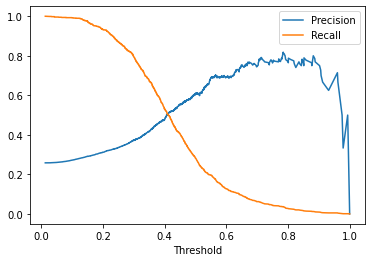

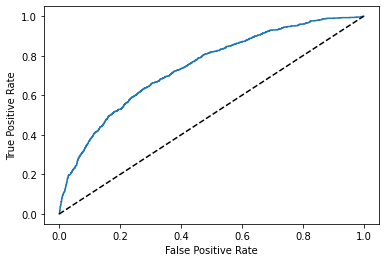

LABEL_Fibrinogen
['Fibrinogen_0', 'Fibrinogen_1', 'Fibrinogen_2', 'Fibrinogen_3', 'Fibrinogen_4', 'Fibrinogen_5', 'Fibrinogen_6', 'Fibrinogen_7', 'Fibrinogen_8', 'Fibrinogen_9', 'Fibrinogen_10', 'Fibrinogen_11', 'Age']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                4920      
                                                                 
 batch_normalization_1 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable par

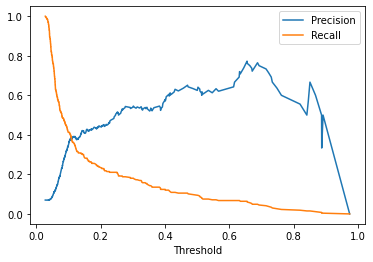

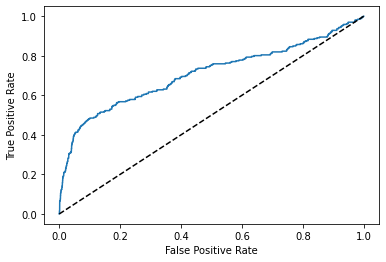

LABEL_AST
['AST_0', 'AST_1', 'AST_2', 'AST_3', 'AST_4', 'AST_5', 'AST_6', 'AST_7', 'AST_8', 'AST_9', 'AST_10', 'AST_11', 'Age']
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                4920      
                                                                 
 batch_normalization_2 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable params: 5,113
Non-trainable params: 24
_______________________________________________________

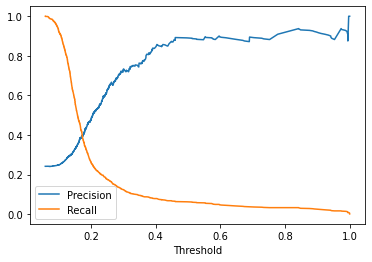

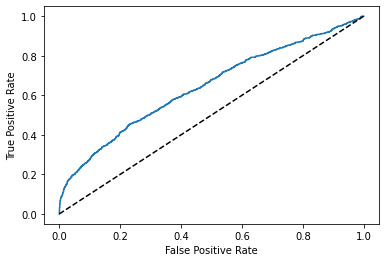

LABEL_Alkalinephos
['Alkalinephos_0', 'Alkalinephos_1', 'Alkalinephos_2', 'Alkalinephos_3', 'Alkalinephos_4', 'Alkalinephos_5', 'Alkalinephos_6', 'Alkalinephos_7', 'Alkalinephos_8', 'Alkalinephos_9', 'Alkalinephos_10', 'Alkalinephos_11', 'Age']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 12)                4920      
                                                                 
 batch_normalization_3 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 12)                156       
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total p

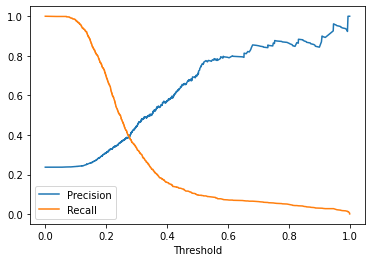

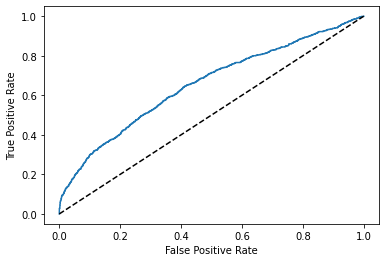

LABEL_Bilirubin_total
['Bilirubin_total_0', 'Bilirubin_total_1', 'Bilirubin_total_2', 'Bilirubin_total_3', 'Bilirubin_total_4', 'Bilirubin_total_5', 'Bilirubin_total_6', 'Bilirubin_total_7', 'Bilirubin_total_8', 'Bilirubin_total_9', 'Bilirubin_total_10', 'Bilirubin_total_11', 'Age']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_4 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 12)                156       
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                  

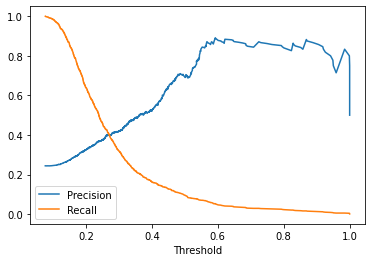

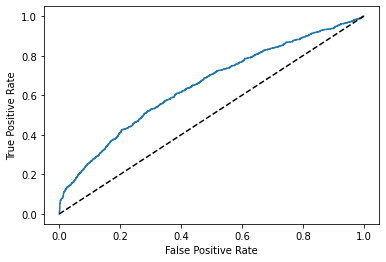

LABEL_Lactate
['Lactate_0', 'Lactate_1', 'Lactate_2', 'Lactate_3', 'Lactate_4', 'Lactate_5', 'Lactate_6', 'Lactate_7', 'Lactate_8', 'Lactate_9', 'Lactate_10', 'Lactate_11', 'Age']
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_5 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 12)                156       
                                                                 
 dense_17 (Dense)            (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable params: 5,113
Non-trainable params: 24
___

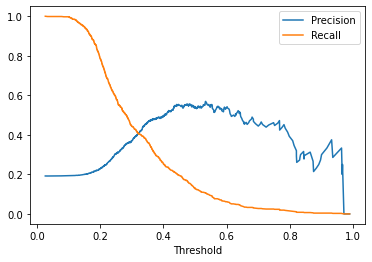

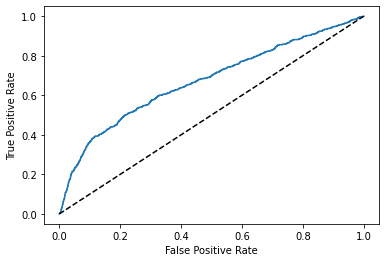

LABEL_TroponinI
['TroponinI_0', 'TroponinI_1', 'TroponinI_2', 'TroponinI_3', 'TroponinI_4', 'TroponinI_5', 'TroponinI_6', 'TroponinI_7', 'TroponinI_8', 'TroponinI_9', 'TroponinI_10', 'TroponinI_11', 'Age']
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_6 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_19 (Dense)            (None, 12)                156       
                                                                 
 dense_20 (Dense)            (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable params: 5,113
No

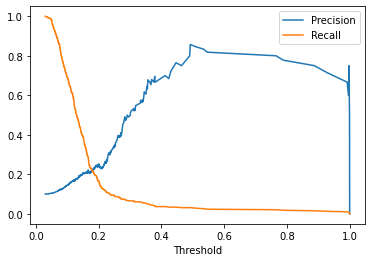

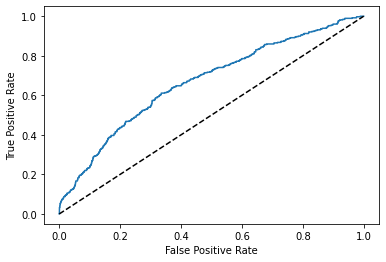

LABEL_SaO2
['SaO2_0', 'SaO2_1', 'SaO2_2', 'SaO2_3', 'SaO2_4', 'SaO2_5', 'SaO2_6', 'SaO2_7', 'SaO2_8', 'SaO2_9', 'SaO2_10', 'SaO2_11', 'Age']
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_7 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 12)                156       
                                                                 
 dense_23 (Dense)            (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable params: 5,113
Non-trainable params: 24
__________________________________________

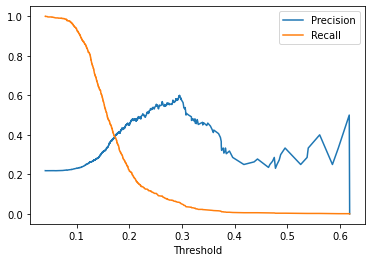

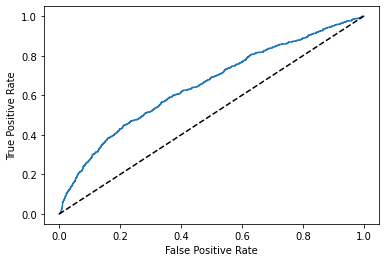

LABEL_Bilirubin_direct
['Bilirubin_direct_0', 'Bilirubin_direct_1', 'Bilirubin_direct_2', 'Bilirubin_direct_3', 'Bilirubin_direct_4', 'Bilirubin_direct_5', 'Bilirubin_direct_6', 'Bilirubin_direct_7', 'Bilirubin_direct_8', 'Bilirubin_direct_9', 'Bilirubin_direct_10', 'Bilirubin_direct_11', 'Age']
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_8 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 12)                156       
                                                                 
 dense_26 (Dense)            (None, 1)                 13        
                     

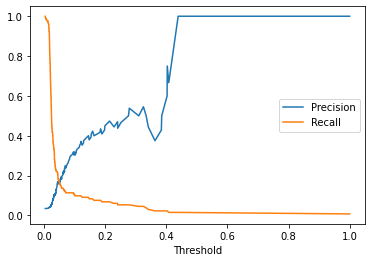

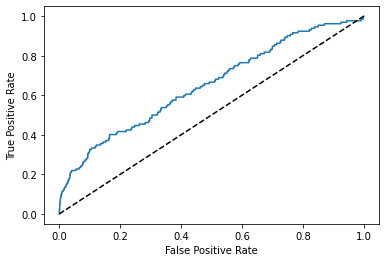

LABEL_EtCO2
['EtCO2_0', 'EtCO2_1', 'EtCO2_2', 'EtCO2_3', 'EtCO2_4', 'EtCO2_5', 'EtCO2_6', 'EtCO2_7', 'EtCO2_8', 'EtCO2_9', 'EtCO2_10', 'EtCO2_11', 'Age']
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_9 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 12)                156       
                                                                 
 dense_29 (Dense)            (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable params: 5,113
Non-trainable params: 24
_____________________________

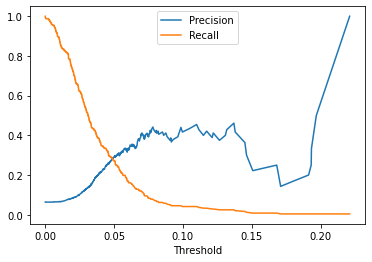

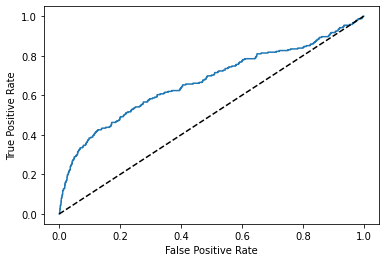

LABEL_Sepsis
['Age']
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 12)                4920      
                                                                 
 batch_normalization_10 (Bat  (None, 12)               48        
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 12)                156       
                                                                 
 dense_32 (Dense)            (None, 1)                 13        
                                                                 
Total params: 5,137
Trainable params: 5,113
Non-trainable params: 24
_________________________________________________________________
Epoch 1/100
428/428 [==============================] - 3s 4ms/step - loss: 0.2791 - accuracy: 0

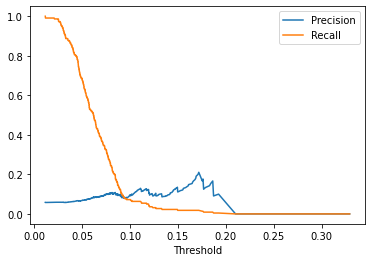

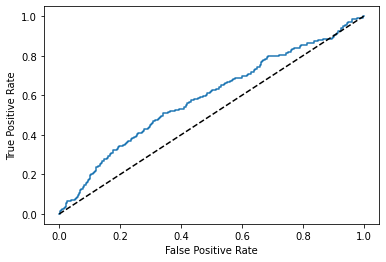

In [11]:
from sklearn import preprocessing
preds_arr = []
for label in labels_to_predict:
    print(label)
    clf = LogisticRegressionCV(class_weight='balanced', penalty='l2', n_jobs=6, cv=10, max_iter=1000, scoring="roc_auc", random_state=seed)
    # clf = LinearSVC(probability=True, class_weight='balanced', kernel='linear')
    # regr = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.1))
    
    
    # cv = RandomizedSearchCV(
    #     SVR(), 
    #     {
    #         "C": [0.5, 1.0], 
    #         "epsilon": [0.1, 0.2]
    #     }, 
    #     cv=5, 
    #     n_jobs=4, 
    #     scoring="roc_auc", 
    #     random_state=seed, 
    #     verbose=1)
    # search = RandomCV(pipe, param_grid, n_jobs=2)
    # search.fit(X_digits, y_digits)
    # print("Best parameter (CV score=%0.3f):" % search.best_score_)
    # print(search.best_params_)

    wanted_features = [l for l in X_train.columns if "_".join(label.split("_")[1:]) in l]
    wanted_features.append("Age")
    print(wanted_features)
    X_train_filtered = X_train.drop('pid', axis=1)#[wanted_features]
    X_test_filtered = X_test.drop('pid', axis=1)#[wanted_features]
    # print(X_train_filtered)
    
    scaler = preprocessing.StandardScaler().fit(X_train_filtered)    
    X_train_scaled = scaler.transform(X_train_filtered)
    X_test_scaled = scaler.transform(X_test_filtered)
    preprocessed_test_scaled = scaler.transform(preprocessed_test_features.drop("pid", axis=1))
    # print(X_train_scaled)
    clf.fit(X_train_scaled, y_train[label])
    # print(X_train_filtered)
    # cv.fit(X_train_filtered, y_train[label])

    # model = Sequential() # create a sequential model
    # model.add(Dense(12, # output neurons in layer       
    #         input_dim=X_train_filtered.shape[1], # number of inputs
    #         activation='relu')) # activation function
    # model.add(BatchNormalization())
    # model.add(Dense(12, activation='relu')) # hidden layer
    # # model.add(Dropout(0.5)) 
    # # model.add(BatchNormalization())
    # model.add(Dense(1, activation='sigmoid')) # output layer
    # model.summary()

    # # fit the model
    # callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    # model.compile(loss='binary_crossentropy', # cost function
    #           optimizer='adam', # use adam as the optimizer
    #           metrics=['accuracy', keras.metrics.AUC(),f1_m,precision_m, recall_m]) # compute accuracy, for scoring
    # model_info = model.fit(X_train_filtered, y_train[label], 
    #     epochs=100,
    #     validation_split=.10,
    #     callbacks=[callback])
    
    # loss, accuracy, auc, f1_score, precision, recall = model.evaluate(X_test, to_categorical(y_test[label]), verbose=1)
    # print(f"loss: {loss}, auc: {auc}, accuracy: {accuracy}, f1_score: {f1_score}, precision: {precision}, recall: {recall}")
    # pred = model.predict(X_test_filtered)
    # pred_train = model.predict(X_train_filtered)
    # pred_test = model.predict(preprocessed_test_features.drop("pid", axis=1))#[wanted_features])
    print(pred, pred_train)
    # pred = pred.squeeze()[:,1]
    # pred_train = pred_train.squeeze()[:,1]
    # pred_test = pred_test.squeeze()[:,1]
    pred = clf.predict_proba(X_test_scaled)[:, 1]
    pred_train = clf.predict_proba(X_train_scaled)[:, 1]
    pred_test = clf.predict_proba(preprocessed_test_scaled)[:, 1]
    # pred = cv.predict(X_test_scaled)
    # pred_train = cv.predict(X_train_scaled)
    print(pred, pred.var())

    preds_arr.append(pd.DataFrame(pred_test, columns=[label]))
    # pred = clf.predict_proba(X_test_scaled)
    # score = roc_auc_score(y_test[label], pred[:, 1])
    # score = roc_auc_score(y_test[label], pred)
    # train_score = roc_auc_score(y_train[label], pred_train)
    # print(f"roc auc score: {score}", train_score)


    precisions, recalls, thresholds = precision_recall_curve(y_test[label], pred)

    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    # mean_squared_error(y_test["LABEL_BaseExcess"], pred[:, 1])
    # fpr, tpr, thresholds = roc_curve(y_test[label], pred[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test[label], pred)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


In [12]:

preds_arr.insert(0, preprocessed_test_features["pid"])
preds = pd.concat(preds_arr, axis=1)
preds["pid"] = preds["pid"].astype(int)
print(preds)

         pid  LABEL_BaseExcess  LABEL_Fibrinogen  LABEL_AST  \
0          0          0.662390          0.353955   0.312136   
1          3          0.270009          0.045708   0.176791   
2          5          0.349185          0.048312   0.102761   
3          7          0.542366          0.847467   0.979168   
4          9          0.339689          0.047908   0.199604   
...      ...               ...               ...        ...   
12659  31647          0.319866          0.042718   0.126017   
12660  31649          0.608405          0.044785   0.085215   
12661  31651          0.439425          0.060673   0.128767   
12662  31652          0.270606          0.050783   0.196294   
12663  31655          0.325866          0.050134   0.213437   

       LABEL_Alkalinephos  LABEL_Bilirubin_total  LABEL_Lactate  \
0                0.359955               0.563057       0.638041   
1                0.258793               0.327941       0.222532   
2                0.142126               0.

In [13]:
def save_submission(submission):

    ## prediction submission paths
    sub_dir = "./submission/"
    sub_file = "submission2.csv"
    sub_path = sub_dir + sub_file


    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)


    ## submission csv header
    # sub_header = ""
    # sub_format = "%.13f"
    submission.to_csv(sub_path, index=False)

In [15]:
preds2 = pd.concat([preds, pd.DataFrame(np.zeros((len(preds), 4)), columns=["LABEL_RRate","LABEL_ABPm","LABEL_SpO2","LABEL_Heartrate"])], axis=1)

In [16]:

# Min-Max Normalization
df = preds2.drop('pid', axis=1)
df_norm = (df-df.min())/(df.max()-df.min())
df_norm = pd.concat((df_norm, preds2.pid), 1)
df_norm.fillna(0, inplace=True)

/tmp/ipykernel_5505/4234201765.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm = pd.concat((df_norm, preds2.pid), 1)


In [17]:
save_submission(df_norm)
